# Quick Example

In [8]:
import pandas as pd
import warnings; warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"
df = pd.read_csv(url, header=0, index_col=0)

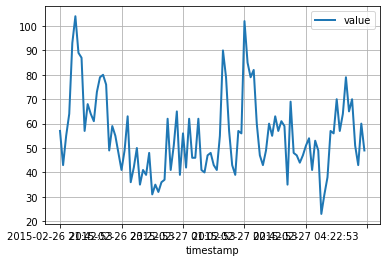

In [9]:
df[:100].plot(linewidth=2)
plt.grid(which='both')
plt.show()

In [10]:
training_data = ListDataset(
    [{"start": df.index[0], "target": df.value[:"2015-04-05 00:00:00"]}],
    freq = "5min"
)

In [11]:
estimator = DeepAREstimator(freq="5min", prediction_length=12, trainer=Trainer(epochs=10))
predictor = estimator.train(training_data=training_data)

100%|█████████| 50/50 [00:02<00:00, 21.84it/s, epoch=10/10, avg_epoch_loss=3.97]


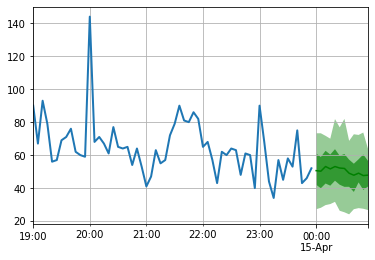

In [12]:
test_data = ListDataset(
    [{"start": df.index[0], "target": df.value[:"2015-04-15 00:00:00"]}],
    freq = "5min"
)

from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry)[-60:].plot(linewidth=2)
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0])
plt.grid(which='both')

# Real Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess; FOLDER_PATH = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
import warnings; warnings.filterwarnings("ignore")
import sys, os; sys.path.append(os.path.dirname(f'{FOLDER_PATH}/utils')); sys.path.append(os.path.dirname(f'{FOLDER_PATH}/scripts'))

from utils.base_helpers import DataReader
import pandas as pd
import numpy as np
import random

In [50]:
import mxnet as mx
import matplotlib.pyplot as plt
from tqdm import tqdm
from gluonts.mx.trainer import Trainer
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution import NegativeBinomialOutput, GaussianOutput, StudentTOutput, ZeroAndOneInflatedBetaOutput, ZeroInflatedBetaOutput, OneInflatedBetaOutput
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions

from utils.gluon_helpers import GluonTSWrapper, GluonTSModel

In [4]:
config={
    "window": {"label_width": 24, "input_width": 48, "shift": 0},
    # "compiler":{"patience": 10, "epochs": 20, "optimizer": "adam", "loss": "mse", "verbose": 1}
}
PLANT_NO = 10
ratios = [0.56095, 0.082, 0.082, 0.08288, 0.0838, 0.0838]

# ratios = [0.56095, 0.082, 0.082 + 0.08288 + 0.0838 + 0.0838]

train_ratio_, valid_ratio_, test_ratio_ = ratios[:3]

data = DataReader(number_of_plants=PLANT_NO)
data.process(train_ratio=train_ratio_, valid_ratio=valid_ratio_, test_ratio=test_ratio_, expand=False)

Train start and end dates:	 2019-01-26 03:00:00 	 2020-10-02 22:00:00
Validation start and end dates:	 2020-10-02 23:00:00 	 2020-12-31 23:00:00
Test start and end dates:	 2021-01-01 00:00:00 	 2021-03-31 23:00:00


In [5]:
ctx = "gpu" if mx.context.num_gpus() else "cpu"
CTX = ctx
PREDICTION_LENGTH = 48 * 1
CONTEXT_LENGTH = 48
freq = "1H"
FREQ = "1H"

In [6]:
wrapper = GluonTSWrapper(data.train_df, data.valid_df, data.test_df, 
                         prediction_length=PREDICTION_LENGTH, context_length=CONTEXT_LENGTH)
wrapper.gluon_df.iloc[:, 1:] = wrapper.gluon_df.iloc[:, 1:].clip(lower=0.001, upper=0.999)

29.14581298828125
8.37942123413086


In [7]:
train_ds, valid_ds, test_ds = wrapper.prepare_gluon_datasets()

100%|███████████████████████████████████████████| 88/88 [00:03<00:00, 27.43it/s]


In [ ]:
model = GluonTSModel(DeepAREstimator, params={
    "num_layers": 2, 
    "num_cells": 200,
    "trainer": Trainer(epochs=200, hybridize=True),
    # "distr_output": ZeroAndOneInflatedBetaOutput(),
    # "distr_output": ZeroInflatedBetaOutput(), # GaussianOutput()
    "distr_output": OneInflatedBetaOutput(),
    "batch_size": 64,
})()
predictor = model.train(training_data=train_ds, num_workers=None)

 34%|██▍    | 17/50 [00:10<00:19,  1.67it/s, epoch=34/200, avg_epoch_loss=-1.78]

In [ ]:
valid_forecast_it, _ = make_evaluation_predictions(valid_ds, predictor=predictor, num_samples=100)
valid_predictions = {k: [] for k in wrapper.plants}
for forecast_entry in tqdm(valid_forecast_it):
    # valid_predictions[int(forecast_entry.item_id)].append(pd.Series(forecast_entry.median, index=forecast_entry.mean_ts.index)[-24:])
    valid_predictions[int(forecast_entry.item_id)].append(forecast_entry.mean_ts[-24:])
    # valid_predictions[int(forecast_entry.item_id)].append(forecast_entry.mean_ts)

valid_predictions = wrapper._prepare_output(valid_predictions)
valid_output = pd.merge(wrapper.valid_df[["rt_plant_id", "production"]], valid_predictions, on=["forecast_dt", "rt_plant_id"]).round(2)

from utils.base_helpers import calculate_wmape

calculate_wmape(valid_output["prediction"], valid_output["production"])

In [ ]:
valid_output[valid_output["rt_plant_id"] == 968][["production", "prediction"]].plot()

In [ ]:
# 4.5 seconds * plant no
# 10 plant 880 it, 47 seconds, 88 * 90

In [ ]:
test_forecast_it, _ = make_evaluation_predictions(test_ds, predictor=predictor, num_samples=10)
test_predictions = {k: [] for k in wrapper.plants}
test_predictions_mean = {k: [] for k in wrapper.plants}
for forecast_entry in tqdm(test_forecast_it):
    test_predictions_mean[int(forecast_entry.item_id)].append(forecast_entry.mean_ts[-24:])
    test_predictions[int(forecast_entry.item_id)].append(pd.Series(forecast_entry.median, index=forecast_entry.mean_ts.index)[-24:])

test_predictions = wrapper._prepare_output(test_predictions)
test_predictions_mean = wrapper._prepare_output(test_predictions_mean)

test_output = pd.merge(wrapper.test_df[["rt_plant_id", "production"]], test_predictions, on=["forecast_dt", "rt_plant_id"]).round(4)
test_output_mean = pd.merge(wrapper.test_df[["rt_plant_id", "production"]], test_predictions_mean, on=["forecast_dt", "rt_plant_id"]).round(4)

In [ ]:
from utils.base_helpers import calculate_wmape

print(calculate_wmape(test_output["prediction"], test_output["production"]))
print(calculate_wmape(test_output_mean["prediction"], test_output_mean["production"]))

In [ ]:
test_output

In [47]:
# best 37-57
test_output.groupby("rt_plant_id").apply(lambda x: calculate_wmape(x["prediction"], x["production"])).sort_values()

rt_plant_id
968     0.509040
1508    0.520706
1518    0.527809
1537    0.534185
1507    0.546152
1527    0.559657
672     0.593254
2180    0.605231
969     0.605455
1484    0.639071
dtype: float64

In [48]:
test_output.reset_index()

,forecast_dt,rt_plant_id,production,prediction
0,2021-01-01 00:00:00,672,0.9657,0.8898
1,2021-01-01 00:00:00,968,0.6323,0.6381
2,2021-01-01 00:00:00,969,0.5739,0.4769
3,2021-01-01 00:00:00,1484,0.1780,0.3470
4,2021-01-01 00:00:00,1507,0.7844,0.9614
...,...,...,...,...
21115,2021-03-29 23:00:00,1508,0.4266,0.3014
21116,2021-03-29 23:00:00,1518,0.1773,0.2561
21117,2021-03-29 23:00:00,1527,0.6341,0.2152
21118,2021-03-29 23:00:00,1537,0.1391,0.2903


<AxesSubplot:xlabel='forecast_dt'>

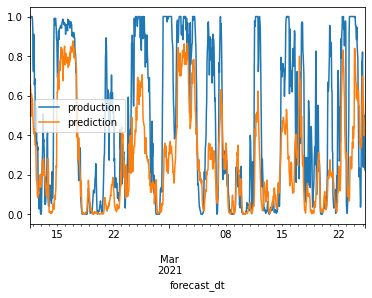

In [38]:
test_output[test_output["rt_plant_id"] == 968][["production", "prediction"]].iloc[1000:2000].plot()

<AxesSubplot:xlabel='forecast_dt'>

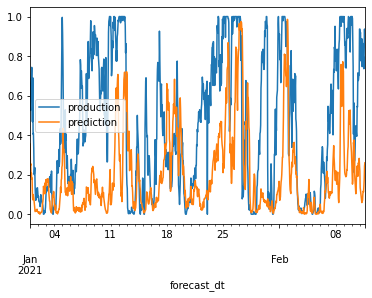

In [39]:
test_output[test_output["rt_plant_id"] == 969][["production", "prediction"]].iloc[:1000].plot()

In [ ]:
train_predictions = {k: [] for k in wrapper.plants}
for forecast_entry in train_forecast_it:
    train_predictions[int(forecast_entry.item_id)].append(forecast_entry.mean_ts) # [-24:])

train_predictions = wrapper._prepare_output(train_predictions)
train_output = pd.merge(wrapper.train_df[["rt_plant_id", "production"]], train_predictions, on=["forecast_dt", "rt_plant_id"]).round(2)

In [22]:
train_forecast_it, _ = make_evaluation_predictions(train_ds, predictor=predictor, num_samples=100)
train_predictions = {k: [] for k in wrapper.plants}
for forecast_entry in train_forecast_it:
    train_predictions[int(forecast_entry.item_id)].append(forecast_entry.mean_ts) # [-24:])

train_predictions = wrapper._prepare_output(train_predictions)
train_output = pd.merge(wrapper.train_df[["rt_plant_id", "production"]], train_predictions, on=["forecast_dt", "rt_plant_id"]).round(2)

<AxesSubplot:xlabel='forecast_dt'>

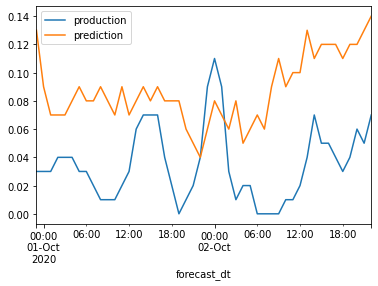

In [23]:
train_output[train_output["rt_plant_id"] == 968][["production", "prediction"]].plot()

<AxesSubplot:xlabel='forecast_dt'>

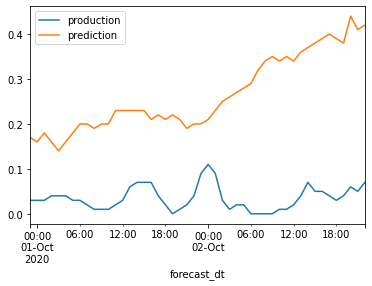

In [82]:
train_output[train_output["rt_plant_id"] == 968][["production", "prediction"]].plot()

In [76]:
df_.index[-48:]

DatetimeIndex(['2020-09-30 23:00:00', '2020-10-01 00:00:00',
               '2020-10-01 01:00:00', '2020-10-01 02:00:00',
               '2020-10-01 03:00:00', '2020-10-01 04:00:00',
               '2020-10-01 05:00:00', '2020-10-01 06:00:00',
               '2020-10-01 07:00:00', '2020-10-01 08:00:00',
               '2020-10-01 09:00:00', '2020-10-01 10:00:00',
               '2020-10-01 11:00:00', '2020-10-01 12:00:00',
               '2020-10-01 13:00:00', '2020-10-01 14:00:00',
               '2020-10-01 15:00:00', '2020-10-01 16:00:00',
               '2020-10-01 17:00:00', '2020-10-01 18:00:00',
               '2020-10-01 19:00:00', '2020-10-01 20:00:00',
               '2020-10-01 21:00:00', '2020-10-01 22:00:00',
               '2020-10-01 23:00:00', '2020-10-02 00:00:00',
               '2020-10-02 01:00:00', '2020-10-02 02:00:00',
               '2020-10-02 03:00:00', '2020-10-02 04:00:00',
               '2020-10-02 05:00:00', '2020-10-02 06:00:00',
               '2020-10-

In [ ]:

# valid_data = lambda date_shift: self.gluon_df.iloc[:(train_l + date_shift) * data.number_of_plants]

test_data = lambda date_shift: self.gluon_df[self.gluon_df.index < self.test_indices[date_shift]]
test_list = [
    self.dataset_helper(test_data(date_shift), is_train=False)
    for date_shift in tqdm(range(24, len(self.test_indices)-24, 24))
]
test_ds = ListDataset([item for sublist in test_list for item in sublist], freq=FREQ)


In [39]:
model = GluonTSModel(DeepAREstimator, params={
    "num_layers": 2, 
    "num_cells": 100,
    "trainer": Trainer(epochs=100, hybridize=False, num_batches_per_epoch=10, learning_rate=1e-3, ctx=ctx),
    "distr_output": ZeroInflatedBetaOutput(),
    "batch_size": 10,
})()
predictor = model.train(training_data=train_ds, validation_data=valid_ds, num_workers=None)
# predictor = model.train(training_data=train_ds, num_workers=None)

100%|████████| 10/10 [00:04<00:00,  2.14it/s, epoch=1/100, avg_epoch_loss=-.161]
4it [00:01,  3.49it/s, epoch=1/100, validation_avg_epoch_loss=-.598]
100%|█████████| 10/10 [00:04<00:00,  2.37it/s, epoch=2/100, avg_epoch_loss=-.64]
4it [00:01,  3.32it/s, epoch=2/100, validation_avg_epoch_loss=-.421]
100%|████████| 10/10 [00:04<00:00,  2.24it/s, epoch=3/100, avg_epoch_loss=-.714]
4it [00:01,  3.16it/s, epoch=3/100, validation_avg_epoch_loss=-.91]
100%|████████| 10/10 [00:04<00:00,  2.30it/s, epoch=4/100, avg_epoch_loss=-.911]
4it [00:01,  3.49it/s, epoch=4/100, validation_avg_epoch_loss=-1.05]
100%|████████| 10/10 [00:04<00:00,  2.32it/s, epoch=5/100, avg_epoch_loss=-.864]
4it [00:01,  3.57it/s, epoch=5/100, validation_avg_epoch_loss=-1.06]
100%|████████| 10/10 [00:04<00:00,  2.39it/s, epoch=6/100, avg_epoch_loss=-.921]
4it [00:01,  3.65it/s, epoch=6/100, validation_avg_epoch_loss=-1.06]
100%|█████████| 10/10 [00:04<00:00,  2.31it/s, epoch=7/100, avg_epoch_loss=-1.1]
4it [00:01,  3.03it/

Early stopping based on learning rate scheduler callback (min_lr was reached).


0.5655368120720448

In [33]:
calculate_wmape(test_output[test_output["rt_plant_id"] == 968]["prediction"], test_output[test_output["rt_plant_id"] == 969]["production"])

0.5482683597807794

In [50]:
valid_output[valid_output["rt_plant_id"] == 969]

,rt_plant_id,production,prediction
forecast_dt,,,
2020-10-02 23:00:00,969,0.01,0.06
2020-10-03 00:00:00,969,0.01,0.07
2020-10-03 01:00:00,969,0.00,0.06
2020-10-03 02:00:00,969,0.00,0.07
2020-10-03 03:00:00,969,0.00,0.08
...,...,...,...
2020-12-27 18:00:00,969,0.34,0.20
2020-12-27 19:00:00,969,0.46,0.18
2020-12-27 20:00:00,969,0.59,0.17


In [53]:
test_output[test_output["rt_plant_id"] == 969].index.nunique()

2112

<AxesSubplot:xlabel='forecast_dt'>

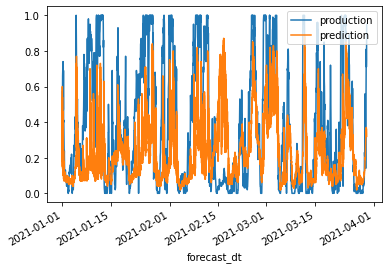

In [43]:
test_output[test_output["rt_plant_id"] == 969][["production", "prediction"]].plot()

In [44]:
valid_forecast_it, _ = make_evaluation_predictions(valid_ds, predictor=predictor, num_samples=100)
valid_predictions = {k: [] for k in wrapper.plants}
for forecast_entry in valid_forecast_it:
    valid_predictions[int(forecast_entry.item_id)].append(forecast_entry.mean_ts) # [-24:])

valid_predictions = wrapper._prepare_output(valid_predictions)
valid_output = pd.merge(wrapper.valid_df[["rt_plant_id", "production"]], valid_predictions, on=["forecast_dt", "rt_plant_id"]).round(2)

<AxesSubplot:xlabel='forecast_dt'>

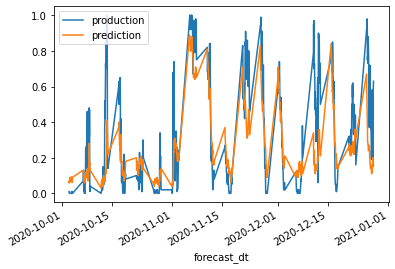

In [45]:
valid_output[valid_output["rt_plant_id"] == 969][["production", "prediction"]].plot()

In [46]:
calculate_wmape(valid_output[valid_output["rt_plant_id"] == 968]["prediction"], valid_output[valid_output["rt_plant_id"] == 969]["production"])

0.36777337769040747

In [47]:
train_forecast_it, _ = make_evaluation_predictions(train_ds, predictor=predictor, num_samples=100)
train_predictions = {k: [] for k in wrapper.plants}
for forecast_entry in train_forecast_it:
    train_predictions[int(forecast_entry.item_id)].append(forecast_entry.mean_ts) # [-24:])

train_predictions = wrapper._prepare_output(train_predictions)
train_output = pd.merge(wrapper.train_df[["rt_plant_id", "production"]], train_predictions, on=["forecast_dt", "rt_plant_id"]).round(2)

<AxesSubplot:xlabel='forecast_dt'>

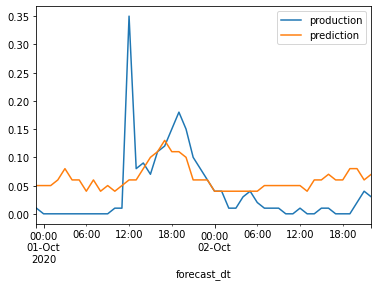

In [48]:
train_output[train_output["rt_plant_id"] == 969][["production", "prediction"]].plot()

In [29]:
len(train_output[train_output["rt_plant_id"] == 969])

48

<AxesSubplot:xlabel='forecast_dt'>

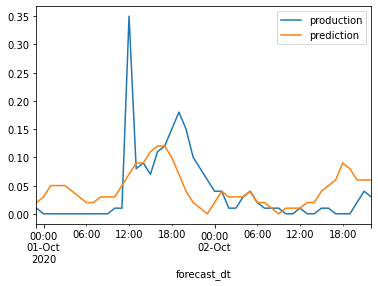

In [27]:
train_output[train_output["rt_plant_id"] == 969][["production", "prediction"]].plot()